### 注意力分数
> 回顾：$$f(x)=\sum_{i}\alpha(x,x_i)y_i=\sum_{i=1}^{n}softmax(-\frac{1}{2}(x-x_i)^2))y_i$$其中$\alpha(x,x_i)$是注意力权重，$-\frac{1}{2}(x-x_i)^2$是注意力分数

 ### 拓展到高维度
 > * 假设query$q\in\mathbb{R}^q$，$m$对$key-value(k_1,v_1),...,$这里$k_i\in\mathbb{R}^k,v_i\in\mathbb{R}^v$
  > * 注意力池化层：$$f(q,(k_1,v_1),...,(k_m,v_m))=\sum_{i=1}^m\alpha(q,k_i)v_i\in\mathbb{R}^v$$$$\alpha(q,k_i)=softmax(a(q,k_i))=\frac{exp(a(q,k_i))}{\sum_{j=1}^m exp(a(q,k_j))}\in\mathbb{R}$$

### Additive Attention
> * 可学参数：$$W_k\in\mathbb{R}^{h\times k},W_q\in\mathbb{R}^{h\times q},W_v\in\mathbb{R}^{h}$$$$a(k,q)=W_v^T tanh(W_k k+W_q q)$$
> * 等价于将query和key合并起来后放入到一个隐藏大小为h，输出大小为1的单隐藏层MLP，即输入大小为$h\times(k+q)$，权重大小为$1\times(k+q),input*weight^T$后得到大小为$h\times 1$

### Scaled Dot-Product Attention
> * 如果query和key都是同样的长度$q,k_i\in\mathbb{R}^d$，那么可以$$a(q,k_i)=<q, k_i>/\sqrt{d}$$
> * 向量化版本
>> * $Q\in\mathbb{R}^{n\times d},K\in\mathbb{R}^{m\times d},V\in\mathbb{R}^{m\times v}$
>> * 注意力分数：$a(Q, K)=QK^T/\sqrt{d}\in\mathbb{R}^{n\times m}$
>> * 注意力池化：$f = softmax(a(Q,K))V\in\mathbb{R}^{n\times v}$

### 总结
> * 注意力分数是query和key的相似度，注意力权重是分数的softmax结果
> * 两种常见的分数计算
>> * 将query和key合并起来进入一个单输入单隐藏层的MLP
>> * 直接将query和key做内积

In [1]:
import math
import torch
from torch import nn
from d2l import limutorch as d2l

In [2]:
"""遮蔽softmax操作"""
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行softmax操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))# 这表示第一个batch中前两列中元素是有用的，第二个batch中前三列元素是有用的

tensor([[[0.4141, 0.5859, 0.0000, 0.0000],
         [0.4961, 0.5039, 0.0000, 0.0000]],

        [[0.3824, 0.2091, 0.4085, 0.0000],
         [0.3860, 0.3710, 0.2430, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4345, 0.2764, 0.2891, 0.0000]],

        [[0.5645, 0.4355, 0.0000, 0.0000],
         [0.2874, 0.2140, 0.3102, 0.1884]]])

In [7]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在下列维度扩展后：
        # queries的形状为：（batch_size,查询个数,1,num_hiddens）
        # keys的形状为：（batch_size,1,键值对个数,num_hideens）
        # 使用广播机制进行相加
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.W_v仅有一个输出，即输出的最后一个维度为1，所以从形状中移除最后一个维度
        # score的形状：（batch-size, 查询个数, 键值对个数）
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状为（batch_size,键值对个数,值个数）
        return torch.bmm(self.dropout(self.attention_weights), values)

In [20]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention =AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
M = attention(queries, keys, values, valid_lens)
M.shape, M, attention.W_k.weight, attention.W_q.weight.shape, attention.W_v.weight, attention.attention_weights.shape

(torch.Size([2, 1, 4]),
 tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],
 
         [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>),
 Parameter containing:
 tensor([[ 0.4994,  0.0686],
         [-0.3224,  0.3604],
         [-0.4340,  0.6448],
         [ 0.0111, -0.3787],
         [ 0.0120,  0.4562],
         [-0.3383,  0.6454],
         [-0.0210, -0.6722],
         [ 0.0419,  0.5650]], requires_grad=True),
 torch.Size([8, 20]),
 Parameter containing:
 tensor([[ 0.3164,  0.0260, -0.1378, -0.2698, -0.0510, -0.1592, -0.0281,  0.3180]],
        requires_grad=True),
 torch.Size([2, 1, 10]))

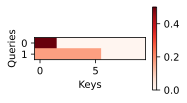

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape(1, 1, 2, 10), xlabel='Keys', ylabel='Queries')

In [17]:
"""缩放点积注意力"""
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # transpose(1, 2)对两个维度进行交换，相当于转置操作，transpose只能作用在两维数据中
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [18]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

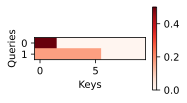

In [19]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')